In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D 
import tqdm
import warnings
from scipy.stats import poisson, norm, chi2
from scipy.optimize import minimize

In [1548]:
plt.style.use('tableau-colorblind10')
#plt.style.use('default')
plt.style.use('../figures/style.mplstyle')

In [914]:
rng = np.random.default_rng()

popt = A, a, B, b = np.loadtxt('lnpopt.txt')

signal_rate = 0.50206743e-3 # hits/sec (delta fxn)
fourweeks = 3600*24*28 # 4 weeks in seconds
day = 3600*24 # one day in seconds
Nsignal = int(signal_rate*fourweeks)
print(Nsignal, 'signal events in 28 days')

E_tot = 8473.6 # keV
M = (29*931.5e3 - 21.895e3) # mass of Si29 (keV)
E_gamma = -M + np.sqrt(M**2 + 2*M*E_tot)
E_nr = E_gamma**2/2/M

mCi = 37000000 # 1 mCi in Bq (decays/sec)

# lowmass resolution
dE = 0.5 #E1/5 # MeV (energy bin width)
#hm_bg_drate = 0.004625 # hits/sec/MeV
#hm_bg_rate = 10*0.00555 #hm_bg_drate*dE # hits/sec in bin

1214 signal events in 28 days


In [915]:
A, a, B, b

(0.5520466933638181,
 0.026313791867575275,
 0.030695612239809735,
 1.7544101643005299)

In [916]:
def thermal_broadening():
    S = 8.4736
    M = (29*931.5 - 21.895)
    z = -1 # aligned with gamma (+1) or antialigned (-1)
    p0 = g0 = -M + np.sqrt(M**2 + 2*M*S) # gamma energy (zero temp)
    K0 = p0**2/2/M # NR energy (zero temp)
    #T = (1e0)*1/40/1e6 # temperature ~1/40 eV
    T = 8.617333262145e-11*(20e-3) # MeV/K x 20mK
    p1 = -M + np.sqrt(M**2 + 2*M*S + M*T - 2*z*np.sqrt(T*M**3)) # nuclear momentum
    K1 = p1**2/2/M # NR energy
    g1 = p1 + z*np.sqrt(M*T) # gamma energy
    dg = p0 - g1 # shift in gamma energy
    dg1 = p0*np.sqrt(T/M) # order of shift?

    Ei = S + T/2
    Ef = p1**2/2/M + p1 + z*np.sqrt(M*T)
    dNR = (K1 - T/2 - K0)


    #print('p0', p0)
    #print('p1', p1)
    #print('T', T)
    #print('T/M', T/M)
    #print('T/S', T/S)
    #print('dp/p0', (p1 - p0)/p0)
    #print('dK/K0', (K1-K0)/K0)
    print('dNR/NR', (K1-T/2-K0)/K0)
    print('S/K sqrt(T/M)', np.sqrt(T/M)*S/K0)
    print('2sqrt(MT)/S', 2*np.sqrt(M*T)/S)
    print('dg/g0', dg/g0)
    #print('dg1/g0', dg1/g0)
    print('sqrt(T/M)', np.sqrt(T/M))
    #print('sqrt(T**2/MS)', np.sqrt(T**2/M/S))
    #print('TS/M^2', T*S/M**2)
    #print('po', po)
    #print('rel error in total E', (S + T/2 - (g1+K1))/(S+T/2)) # numerical errors
    #print('rel error in total E', (Ei-Ef)/Ef)
    #print('rel error in total p', (g1 - p1 - z*np.sqrt(M*T))/np.sqrt(M*T))
    #print(np.sqrt(M*T), S)
    #print(g1-p0)
    print('shift of gamma energy', dg*1e6, 'eV')
    print('shift of NR deposit', dNR*1e6, 'eV')


thermal_broadening()

dNR/NR 5.089905112222482e-05
S/K sqrt(T/M) 5.092301883699863e-05
2sqrt(MT)/S 5.090703860767565e-05
dg/g0 7.988283266253065e-09
sqrt(T/M) 7.990741609215168e-09
shift of gamma energy 0.06767889537684368 eV
shift of NR deposit 0.06767847916615798 eV


In [917]:

def doubleexp(x, A, a, B, b):
    return A*np.exp(-x/a) + B*np.exp(-x/b)

def singleexp(x, A, a):
    return A*np.exp(-x/a)

def intexp(x1, x2, A, a):
    return A*a*(np.exp(-x1/a) - np.exp(-x2/a))

def inverseexpcdf(y, x1, x2, a):
    return -a*np.log((1-y)*np.exp(-x1/a) + y*np.exp(-x2/a))

def intdoubleexp(x1, x2, A, a, B, b):
    return A*a*(np.exp(-x1/a) - np.exp(-x2/a)) + B*b*(np.exp(-x1/b) - np.exp(-x2/b))

def doubleexp_bin_heights(bins, A, a, B, b):
    return intdoubleexp(bins[:-1], bins[1:], A, a, B, b)

def doubleexp_rate(popt, x1 = 0, x2 = np.inf):
    return intdoubleexp(x1, x2, *popt)


def sample_doubleexp(N, x1, x2, popt):
    A, a, B, b = popt

    rates = np.array([intexp(x1, x2, A, a), intexp(x1, x2, B, b)])

    choices = rng.choice(2, size = N, p = 1-rates/rates.sum())

    exp_scales = a*choices + b*(1-choices)

    rands = rng.random(size = N)

    return inverseexpcdf(rands, x1, x2, exp_scales)

def gauss(x, x0, sig):
    return norm.pdf((x-x0)/sig)/sig

def gauss_norm(x1, x2, x0, sig):
    return norm.cdf((x2-x0)/sig) - norm.cdf((x1-x0)/sig)

def gauss_bin_heights(bins, x0, sig):
    s = (bins-x0)/sig
    return (norm.cdf(s[1:]) - norm.cdf(s[:-1]))/gauss_norm(bins[0], bins[-1], x0, sig)

def deriv_gaussbinheights_mean(bins, x0, sig):
    s = (bins-x0)/sig
    normalization = gauss_norm(bins[0], bins[-1], x0, sig)
    return (norm.pdf(s[:-1]) - norm.pdf(s[1:]))/(sig*normalization) - (norm.cdf(s[:-1]) - norm.cdf(s[1:]))*(norm.pdf(s[-1]) - norm.pdf(s[0]))/(sig*normalization**2)

def deriv_gaussbinheights_std(bins, x0, sig):
    s = (bins-x0)/sig
    normalization = gauss_norm(bins[0], bins[-1], x0, sig)
    return (s[:-1]*norm.pdf(s[:-1]) - s[1:]*norm.pdf(s[1:]))/(sig*normalization) - (norm.cdf(s[:-1]) - norm.cdf(s[1:]))*(s[-1]*norm.pdf(s[-1]) - s[0]*norm.pdf(s[0]))/(sig*normalization**2)


In [918]:
x0 = 5
sig = 4
xbins = np.linspace(-5, 15, 100)

gaussP = gauss_bin_heights(xbins, x0, sig)


print(gauss(xbins[15], x0, sig), norm.pdf((xbins[15]-x0)/sig)/sig)

0.021856563476260627 0.021856563476260627


In [963]:
# expected Fano noise at 1.3 keV
eps_Si = 3.8e-3
Fano_Si = 0.15
n_avg = E_nr/eps_Si
sigma_F = E_nr*Fano_Si*np.sqrt(n_avg)/n_avg
sigma_F

0.010662364123403954

(0.7310255472033077, 0.7310255472033078)

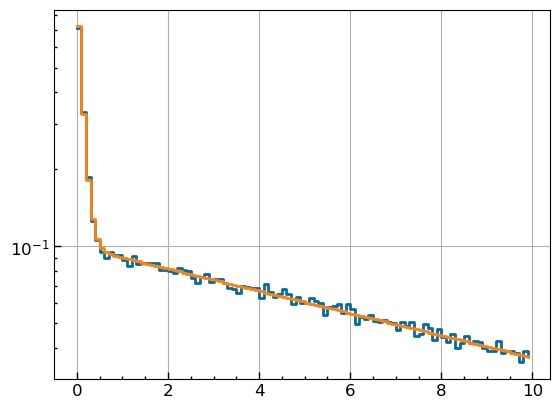

In [919]:
# testing functions and showing how to use sampling/pdf/bin_height functions
test = np.array([1., 0.1, 0.1, 10.])

x1 = 1e-3
x2 = 10.
N = 100_000
livetime = N/doubleexp_rate(test, x1, x2)
Es = sample_doubleexp(N, x1, x2, test)

Espace = np.linspace(x1, x2, 5000)

cts, bins = np.histogram(Es, bins = 100)
db = bins[1:] - bins[:-1]

spec = cts/livetime/db


plt.figure()
plt.grid()
plt.semilogy()
#plt.plot(Espace, doubleexp(Espace, *test))
plt.step(bins[:-1], spec, where = 'post')
plt.step(bins[:-1], doubleexp_bin_heights(bins, *test)/db, where = 'post')


sum(spec*db), doubleexp_rate(test, x1, x2)


1214 174596
1.8212894016269208 70.44079402601346 8.392901406904139


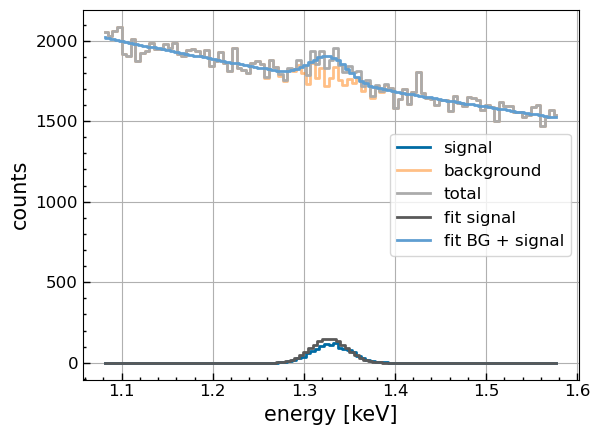

In [1564]:
class Resolution:

    def __init__(self, sigma, E = E_nr, dE = dE, Ebounds = None, signal_rate = signal_rate, exposure = fourweeks, Nbins = 100, popt = popt, bg_multiplier = 1, verbosity = 0, guess_randomly = True, random_radius = 0.01, opt_method = 'L-BFGS-B'):
        self.verbosity = verbosity
        self.analyzed = False

        self.signal_rate = signal_rate
        self.exposure = exposure
        self.N_signal = int(signal_rate*exposure) # number of signal events to sample in ROI

        # signal position and width
        self.E = E # energy of delta-fxn [keV]
        self.sigma = sigma # resolution of delta-fxn [keV]

        # energy binning and ROI
        self.Nbins = Nbins
        if Ebounds is None:
            self.dE = dE # width of energy ROI
            self.E1 = E - dE/2 # bounds of energy ROI [keV]
            self.E2 = E + dE/2 # [keV]
        else:
            self.E1 = Ebounds[0]
            self.E2 = Ebounds[-1]
            self.dE = self.E2 - self.E1

        # bin edges
        self.Ebins = np.linspace(self.E1, self.E2, self.Nbins, endpoint = True)
        # bin centers
        self.Es = (self.Ebins[1:] + self.Ebins[:-1])/2 
        # bin widths
        self.dEs = np.diff(self.Ebins)

        # fit params to doubleexp background dist
        self.popt = popt*np.array([bg_multiplier, 1, bg_multiplier, 1])
        self.A, self.a, self.B, self.b = popt
        
        # background rate [Hz]
        self.bg_multiplier = bg_multiplier # unitless modifier to background
        self.background_rate = doubleexp_rate(self.popt, self.E1, self.E2)
        self.N_background = int(self.background_rate*self.exposure)
        self.N_total = self.N_signal + self.N_background

        self.background_spec = lambda E: doubleexp(E, *self.popt) # hits/sec/keV at energy E in keV

        # "rates" from each constituent exponential
        self.rates = np.array([intexp(self.E1, self.E2, self.A, self.a), intexp(self.E1, self.E2, self.B, self.b)]) # Hz

        self.guess_randomly = guess_randomly
        self.random_radius = random_radius

        self.opt_method = opt_method
        self.minimize_opts = {'maxiter': 1000_000, 'eps': 0.0001}
        
        if self.verbosity:
            print(self.N_signal, 'signal events')
            print(self.N_background, 'background events')
            if self.verbosity > 1:
                print('signal', self.signal_rate, 'Hz')
                print('background', self.background_rate, 'Hz')
                print('exposure', self.exposure/day, 'days')
                if self.guess_randomly:
                    print('random radius =', self.random_radius)
                print('spectrum function assigned, ready to generate')


    def generate_signal(self):
        self.signal = rng.normal(loc = self.E, scale = self.sigma, size = self.N_signal)
    

    def generate_background(self):
        choices = rng.choice(2, size = self.N_background, p = 1-self.rates/self.rates.sum())
        exp_scales = a*choices + b*(1-choices)
        rands = rng.random(size = self.N_background)
        self.background = inverseexpcdf(rands, self.E1, self.E2, exp_scales)


    def analyze_null(self, min_attempts = 40):
        self.generate_background()
        self.background_hist, _ = np.histogram(self.background, bins = self.Ebins)

        self.background_Hz = doubleexp_bin_heights(self.Ebins, *self.popt)
        self.background_P = self.background_Hz/self.background_Hz.sum()



        def like_and_jac_null(y):
            nb, ns, x0, sig = y
            gauss_P = gauss_bin_heights(self.Ebins, x0, sig)
            qi = nb*self.background_P + ns*gauss_P
            L = nb + ns - (self.background_hist*np.log(qi)).sum()
            dL = np.array([
                1 - (self.background_hist*self.background_P/qi).sum(),
                1 - (self.background_hist*gauss_P/qi).sum(),
                -(self.background_hist*ns*deriv_gaussbinheights_mean(self.Ebins, x0, sig)/qi).sum(),
                -(self.background_hist*ns*deriv_gaussbinheights_std(self.Ebins, x0, sig)/qi).sum()
            ])
            return L, dL
        
        # params: [nb, ns, mu, sig]
        bounds = [(0, np.inf), (0, np.inf), (self.E1, self.E2), (np.diff(self.Ebins).mean()/100, np.inf)]

        L_nbg = self.N_total - (self.background_hist*np.log((self.N_background*self.background_P))).sum()

        L_ybg = L_nbg + abs(L_nbg)/10

        with warnings.catch_warnings():
            warnings.simplefilter('ignore')

            attempts = 0

            while (L_ybg > L_nbg) or (attempts < min_attempts):
                guess = abs(rng.standard_normal(size = 4)*self.random_radius + 1)*np.array([1, self.N_background, self.E, self.dE])
                #try:
                opt = minimize(like_and_jac_null, x0 = guess, method = self.opt_method, bounds = bounds, jac = True, options = self.minimize_opts)
                #except :
                #pass
                if opt.success:
                    attempts += 1
                    Lnew = opt.fun
                    if Lnew < L_ybg:
                        L_ybg = Lnew
                elif attempts > 100:
                    print(opt)
                    raise Exception(opt.message)

        return 2*(L_nbg - L_ybg)
        # log-likelihood ratio - square root of this is a standard normal variate


    def analyze(self):
        self.generate_signal()
        self.generate_background()

        self.signal_hist, _ = np.histogram(self.signal, bins = self.Ebins)
        self.background_hist, _ = np.histogram(self.background, bins = self.Ebins)
        self.hist = self.signal_hist + self.background_hist

        self.gauss_P = gauss_bin_heights(self.Ebins, self.E, self.sigma)
        self.gauss_Hz = self.signal_rate*self.gauss_P

        self.background_Hz = doubleexp_bin_heights(self.Ebins, *self.popt)
        self.background_P = self.background_Hz/self.background_Hz.sum()
        
        self.L_nbg = self.N_total - (self.hist*np.log((self.N_total*self.background_P))).sum()

        def like(y):
            nb, ns, x0, sig = y*self.true
            gauss_P = gauss_bin_heights(self.Ebins, x0, sig)
            return nb + ns - (self.hist*np.log(nb*self.background_P + ns*gauss_P)).sum()

        def like_and_jac(y):
            nb, ns, x0, sig = y*self.true
            gauss_P = gauss_bin_heights(self.Ebins, x0, sig)
            qi = nb*self.background_P + ns*gauss_P
            L = nb + ns - (self.hist*np.log(qi)).sum()
            dL = np.array([
                1 - (self.hist*self.background_P/qi).sum(),
                1 - (self.hist*gauss_P/qi).sum(),
                -(self.hist*ns*deriv_gaussbinheights_mean(self.Ebins, x0, sig)/qi).sum(),
                -(self.hist*ns*deriv_gaussbinheights_std(self.Ebins, x0, sig)/qi).sum()
            ])*self.true
            return L, dL

        def jac(y):
            nb, ns, x0, sig = y*self.true
            gauss_P = gauss_bin_heights(self.Ebins, x0, sig)
            qi = nb*self.background_P + ns*gauss_P
            return np.array([
                1 - (self.hist*self.background_P/qi).sum(),
                1 - (self.hist*gauss_P/qi).sum(),
                -(self.hist*ns*deriv_gaussbinheights_mean(self.Ebins, x0, sig)/qi).sum(),
                -(self.hist*ns*deriv_gaussbinheights_std(self.Ebins, x0, sig)/qi).sum()
            ])*self.true


        self.L_ybg_func = lambda x: like(x)
        self.jacL_ybg_func = lambda x: jac(x)
        self.like_and_jac_func = like_and_jac

        # params: [nb, ns, mu, sig]
        self.bounds = [(0, np.inf), (0, np.inf), (self.E1/self.E, self.E2/self.E), (np.diff(self.Ebins).mean()/100/self.dE, np.inf)]


        self.true = np.array([self.N_background, self.N_signal, self.E, self.sigma])
        self.guess1 = np.array([self.N_background+self.N_signal, 0, self.E, self.sigma])/self.true
        self.guess2 = np.array([self.N_background, self.N_signal, self.E, self.sigma])/self.true
        self.guess3 = np.array([1.3, 1.3, 1, 1])
        self.L_ybg = self.L_nbg + abs(self.L_nbg)/10

        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            if self.guess_randomly:
                attempts = 0
                Ltrue = self.L_ybg_func(np.ones(4))

                while self.L_ybg > Ltrue:
                    self.guess = rng.standard_normal(size = 4)*self.random_radius + 1
                    #try:
                    self.opt = minimize(like_and_jac, x0 = self.guess, method = self.opt_method, bounds = self.bounds, jac = True, options = self.minimize_opts)
                    #except :
                    #pass
                    if self.opt.success:
                        attempts += 1
                        self.L_ybg = self.L_ybg_func(self.opt.x)
                    if attempts%10_000 == 0 and self.verbosity > 1:
                        print(f'{attempts:,} attempts')
                
                if self.verbosity:
                    print(f'optimization succeeded after {attempts:,} attempts')
            else:

                for guess in (self.guess1, self.guess2, self.guess3):
                    opt = minimize(like_and_jac, x0 = guess, method = 'SLSQP', bounds = self.bounds, jac = True, options = minimize_opts)
                    # SLSQP
                    # L-BFGS-B

                    if not opt.success:
                        print(opt)
                        raise Exception(opt.message)

                    Lnew = self.L_ybg_func(opt.x)
                    Lguess = self.L_ybg_func(guess)
                    print(self.L_ybg, Lguess, Lnew, Lnew<=self.L_ybg, Lnew<=Lguess, Lnew<=self.L_ybg_func(np.ones(4)))

                    if Lnew <= self.L_ybg:
                        self.L_ybg = Lnew
                        self.opt = opt
                        self.guess = guess

        #self.L_ybg = - (self.hist*np.log(self.N_background*self.background_P + self.N_signal*self.gauss_P)).sum()

        self.chi22 = 2*(self.L_nbg - self.L_ybg)
        # log-likelihood ratio - square root of this is a standard normal variate
        if self.chi22 < 0:
            raise Exception('that\'s not good')

        self.true_background = self.background_P*self.N_background
        self.true_signal = self.gauss_P*self.N_signal
        self.true_total = self.true_background + self.true_signal

        self.fit_background = self.background_P*self.opt.x[0]*self.N_background
        self.fit_signal = self.gauss_P*self.opt.x[1]*self.N_signal
        self.fit_total = self.fit_background+self.fit_signal

        # naive chi-squared
        self.expec = self.N_total*self.background_P
        self.chi2 = (((self.hist - self.expec)**2)/self.expec).sum()/(self.Nbins - 1)

        self.analyzed = True

    # end of Resolution.analyze()

    def contour(self, mu_range, sigma_range, opt_method = 'L-BFGS-B', redo_analysis = True, repeat_minimum = 10, random_radius = None):
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            self.mu_range = mu_range
            self.sigma_range = sigma_range

            if random_radius is None:
                random_radius = self.random_radius

            if not self.analyzed:
                self.analyze()

            def like_and_jac_fixedpeak(y, gauss_P):
                nb = y[0]*self.N_background
                ns = y[1]*self.N_signal
                qi = nb*self.background_P + ns*gauss_P
                L = nb + ns - (self.hist*np.log(qi)).sum()
                dL = np.array([
                    1 - (self.hist*self.background_P/qi).sum(),
                    1 - (self.hist*gauss_P/qi).sum()
                ])*np.array([self.N_background, self.N_signal])
                return L, dL


            bounds2 = 2*[(0,np.inf)]
            minimize_opts = {'maxiter': 1000_000, 'eps': 0.0001}

            Ls = np.zeros((len(sigma_range), len(mu_range)))
            nbfit = np.zeros((len(sigma_range), len(mu_range)))
            nsfit = np.zeros((len(sigma_range), len(mu_range)))

            for i, sig in enumerate(sigma_range):
                for j, x0 in enumerate(mu_range):
                    #print(x0, sig)
                    #print(self.Ebins[:20])
                    gauss_P = gauss_bin_heights(self.Ebins, x0, sig)
                    #print(gauss_P[:20])
                    Lguess = like_and_jac_fixedpeak(np.array([1,1]), gauss_P)[0]
                    Lnew = Lguess + abs(Lguess)/10
                    #print(Lguess, Lnew, Lnew > Lguess)
                    Nrepeats = 0
                    while Lnew > Lguess or Nrepeats < repeat_minimum:
                        guess = abs(rng.normal(1, random_radius, size = 2))
                        opt = minimize(like_and_jac_fixedpeak, x0 = guess, method = opt_method, bounds = bounds2, jac = True, options = minimize_opts, args = (gauss_P,))
                        if opt.success:
                            Llatest = opt.fun
                            if Llatest < Lnew:
                                Lnew = Llatest
                                opt_best = opt
                            Nrepeats += 1

                    Ls[i,j] = Lnew
                    nbfit[i,j] = opt_best.x[0]
                    nsfit[i,j] = opt_best.x[1]

            if redo_analysis: 
                imin, jmin = np.unravel_index(np.argmin(Ls), Ls.shape)
                Lmin = Ls.min()
                newguess = np.array([nbfit[imin, jmin], nsfit[imin, jmin], mu_range[jmin], sigma_range[imin]])
                attempts = 0
                while self.L_ybg > Lmin:
                    self.guess = rng.standard_normal(size = 4)*self.random_radius + newguess/self.true
                    self.opt = minimize(self.like_and_jac_func, x0 = self.guess, method = self.opt_method, bounds = self.bounds, jac = True, options = self.minimize_opts)

                    if self.opt.success:
                        attempts += 1
                        self.L_ybg = self.L_ybg_func(self.opt.x)
                    if attempts%1_000 == 0 and self.verbosity > 1:
                        print(f'{attempts:,} attempts')
                if self.verbosity:
                    print(f'optimization succeeded after {attempts:,} attempts')


                self.chi22 = 2*(self.L_nbg - self.L_ybg)
                # log-likelihood ratio - square root of this is a standard normal variate
                if self.chi22 < 0:
                    raise Exception('that\'s not good')

                self.fit_background = self.background_P*self.opt.x[0]*self.N_background
                self.fit_signal = self.gauss_P*self.opt.x[1]*self.N_signal
                self.fit_total = self.fit_background+self.fit_signal

            return Ls


    def histogram(self, display_chi = True, plot_line = False, **kwargs):
        plt.figure()
        plt.grid()

        plt.xlabel(r'energy [keV]')
        plt.ylabel('counts')
        #plt.title(f'{self.exposure/3600/24:.2g} days, {self.sigma*1e3:.2g}' + r' keV$_\text{ee}$ resolution')

        plt.step(self.Es, self.signal_hist, where = 'mid', label = 'signal')
        plt.step(self.Es, self.background_hist, where = 'mid', label = 'background', alpha = 0.5)
        plt.step(self.Es, self.hist, where = 'mid', label = 'total')


        #plt.step(self.Es, self.background_Hz*self.exposure, label = 'expected/scaled')
        #plt.step(self.Es, self.expec, alpha = 0.8, label = 'no signal')
        #plt.step(self.Es, self.true_signal, label = 'true signal')
        #plt.step(self.Es, self.true_background, label = 'bg with signal')
        #plt.step(self.Es, self.true_signal+self.true_background, label = 'true total')
        #plt.plot(self.Es, self.pdf_spec, alpha = 0.8, label = 'pdf')
        plt.step(self.Es, self.fit_signal, label = 'fit signal', alpha = 1)
        #plt.step(self.Es, self.fit_background, label = 'fit bg')
        plt.step(self.Es, self.fit_signal+self.fit_background, label = 'fit BG + signal', alpha = 1)


        if plot_line:
            plt.axvline(self.E, color = 'k', linestyle = 'dashed', linewidth = 1.5, label = 'true energy')

        
        if display_chi:
            plt.text(self.Ebins[self.Nbins//4], self.hist[self.Nbins//4]/4, f'chi^2 = {self.chi2}')

        plt.legend()

bg_mult = 10
tr = Resolution(0.02, verbosity = 0, bg_multiplier = bg_mult, random_radius = 0.2, opt_method = 'L-BFGS-B')
tr.analyze()

tr.histogram(display_chi = False)


print(tr.N_signal, tr.N_background)
print(tr.chi2, tr.chi22, np.sqrt(tr.chi22))
#plt.savefig('../figures/sim_4wk_example.pdf')

In [921]:
tr.sigma, tr.N_total

(0.02, 175810)

In [922]:
tr.jacL_ybg_func(np.ones(4))

array([ 3.80706464, -3.80706464, 76.9259499 ,  8.83442667])

In [923]:
# df/dq = df/dx dx/dq
# q = x/x0
# x = q x0
# dx/dq = d/dq(q x0) = x0
# df/dq = x0 df/dx

76.92594989981669


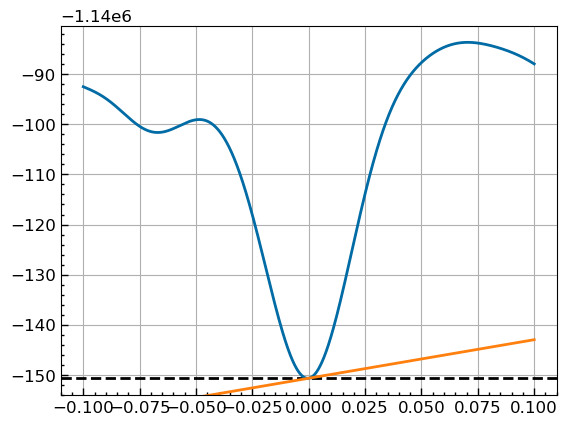

In [924]:
eps = np.linspace(-0.1, 0.1, 10_000)

idx = 2
idx_arr = np.zeros((1,4))
idx_arr[0,idx] = 1.

guesses = np.ones((1,4)) + np.expand_dims(eps, -1)*idx_arr
Ls = np.zeros(eps.shape)
for i, g in enumerate(guesses):
    Ls[i] = tr.L_ybg_func(g)

L1 = tr.L_ybg_func(np.ones(4))
dL = tr.jacL_ybg_func(np.ones(4))[idx]

plt.figure()
plt.grid()
plt.axhline(L1, color = 'k', linestyle = 'dashed')
plt.plot(eps, Ls)
wind = plt.axis()
plt.plot(eps, L1 + dL*eps)
plt.axis(wind)
print(dL)

In [925]:
tr.background_rate*(2e10/mCi)/tr.bg_multiplier

3.9011548486709926

In [926]:
tr.background_rate*540.54054

39.01154844769838

In [927]:
doubleexp_rate(popt, tr.Ebins[0], tr.Ebins[-1])

0.0072171364700413364

In [ ]:
tr.popt # [nb, ns, mu, sig]

array([5.52046693, 0.02631379, 0.30695612, 1.75441016])

In [929]:
popt

array([0.55204669, 0.02631379, 0.03069561, 1.75441016])

In [930]:
tr.opt

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -1140151.1008095555
        x: [ 9.997e-01  1.044e+00  9.996e-01  9.603e-01]
      nit: 10
      jac: [-1.331e+00 -7.987e-01 -7.455e-01  6.611e+00]
     nfev: 15
     njev: 15
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [931]:
tr.chi2, np.sqrt(tr.chi22)

(1.3061109134366942, 7.673045824451906)

In [932]:
tr.L_nbg, tr.L_ybg_func(tr.guess1), tr.L_ybg_func(tr.guess2), tr.L_ybg_func(tr.guess3), tr.L_ybg_func(tr.guess), tr.L_ybg, tr.L_ybg_func(tr.opt.x), tr.opt.fun

(-1140121.6629934434,
 -1140121.6629934434,
 -1140150.6716773661,
 -1133533.9330133959,
 -1140043.0966951805,
 -1140151.1008095555,
 -1140151.1008095555,
 -1140151.1008095555)

In [ ]:
Ntrials = 1000
best_resolution = 400
worst_resolution = 4
sigmas = E_nr*np.exp(np.log(1/best_resolution) + (np.log(1/worst_resolution) - np.log(1/best_resolution))*rng.random(size = Ntrials))
chis = np.zeros(sigmas.shape)
chis2 = np.zeros(sigmas.shape)
fit_lines = np.zeros(sigmas.shape)

for i, sigma in enumerate(tqdm.tqdm(sigmas)):
    res = Resolution(sigma, signal_rate = signal_rate, exposure = fourweeks, bg_multiplier = bg_mult)
    res.analyze()
    chis[i] = res.chi2
    chis2[i] = res.chi22
    fit_lines[i] = res.opt.x[2]*res.true[2]

res.opt

100%|██████████| 1000/1000 [00:27<00:00, 36.58it/s]


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1140202.1829522243
       x: [ 1.005e+00  3.499e-01  1.002e+00  1.507e-01]
     nit: 30
     jac: [ 9.198e-03  8.308e-05  1.588e-02 -5.023e-03]
    nfev: 66
    njev: 29

In [934]:
res.N_signal, res.N_background # highmass1

(1214, 174596)

In [966]:
sigma_F

0.010662364123403954

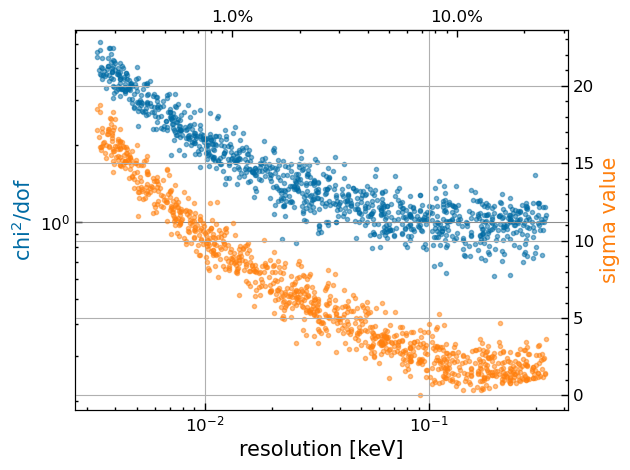

In [965]:
sigma_plot = sigmas#np.sqrt(sigmas**2 - sigma_F**2)
plt.figure()
ax = plt.gca()
ax.loglog()
#ax.set_title('chi-squared vs. resolution in highmass')
ax.set_xlabel(r'resolution [keV]')
ax.set_ylabel('chi$^2$/dof', color = 'C0')
ax.axhline(1, color = 'grey', linewidth = 0.5)
ax.scatter(sigma_plot, chis, marker = '.', alpha = 0.5)
wind0 = ax.axis()
ax.set_ylim(wind0[2]/3, wind0[3])
#ax.set_ylim(wind0[2], 3*wind0[3])

col2 = 'C1'
ax1 = ax.twinx()
#ax1.tick_params(axis = 'y', which = 'both', color = col2)
#ax1.set_ylabel('sqrt(log likelihood ratio)', color = col2, rotation = 90)
ax1.set_ylabel('sigma value', color = col2, rotation = 90)
#ax1.scatter(sigma_plot, chis2, marker = '.', alpha = 0.5, color = col2)
ax1.scatter(sigma_plot, np.sqrt(chis2), marker = '.', alpha = 0.5, color = col2)
#ax1.semilogy()
wind1 = ax1.axis()

#ax.grid(axis = 'x')
ax.grid()
ax1.grid()
ax1.set_ylim(wind1[2], wind1[3]*1.2)

E_to_P = lambda E: 100*E/(E_nr)
P_to_E = lambda P: E_nr*P/100

x2 = ax.secondary_xaxis('top', functions = (E_to_P, P_to_E))
#x2.set_xlabel('percent resolution (%)')
x2.get_xaxis().set_major_formatter('{x}%')


plt.tight_layout()
plt.savefig('../figures/sim_4wk_chi2.pdf')

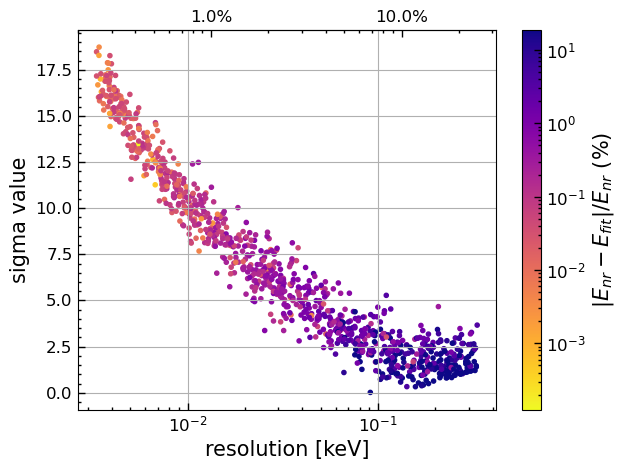

In [ ]:
plt.figure()
ax = plt.gca()
ax.grid()
#ax.loglog()
ax.semilogx()
#ax.set_title('chi-squared vs. resolution in highmass')
ax.set_xlabel(r'resolution [keV]')
ax.set_ylabel('sigma value')

cdata = 100*abs((fit_lines - E_nr)/E_nr)

cnorm = mpl.colors.LogNorm(vmax = max(cdata), vmin = min(cdata))
cmap = plt.cm.plasma_r

ax.scatter(sigmas, np.sqrt(chis2), marker = '.', c = cdata, cmap = cmap, norm = cnorm)
plt.colorbar(mpl.cm.ScalarMappable(norm = cnorm, cmap = cmap), ax = ax, orientation = 'vertical', label = r'$|E_{nr} - E_{fit/E_{nr}$ (%)')


E_to_P = lambda E: 100*E/(E_nr)
P_to_E = lambda P: E_nr*P/100

x2 = ax.secondary_xaxis('top', functions = (E_to_P, P_to_E))
#x2.set_xlabel('percent resolution (%)')
x2.get_xaxis().set_major_formatter('{x}%')

plt.tight_layout()
plt.savefig('../figures/sim_4wk_colored_chi2.pdf')

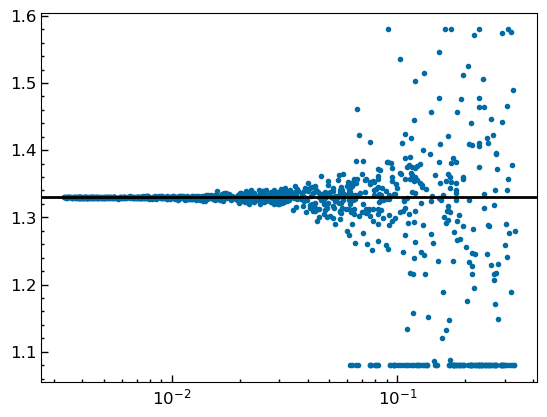

In [937]:
plt.semilogx(sigmas, fit_lines, '.')
plt.axhline(E_nr, color = 'k')

In [998]:
1 - 2*norm.sf(2)

0.9544997361036416

In [938]:
sum(chis2 < 0), len(chis2)

(0, 1000)

In [ ]:
Ntrials = 10_000
best_resolution = 400
worst_resolution = 4
Elow = E_nr - dE/2
Ehigh = E_nr + dE/2
sigmas2 = E_nr*np.exp(np.log(1/best_resolution) + (np.log(1/worst_resolution) - np.log(1/best_resolution))*rng.random(size = Ntrials))
peaks2 = np.exp(np.log(Elow) + (np.log(Ehigh) - np.log(Elow))*rng.random(size = Ntrials))
chis_two = np.zeros(sigmas2.shape)
chis_two2 = np.zeros(sigmas2.shape)
# [nb, ns, mu, sig]

for i, (peak, sigma) in enumerate(tqdm.tqdm(zip(peaks2,sigmas2), total = Ntrials)):
    res = Resolution(sigma, signal_rate = signal_rate, Ebounds = (Elow, Ehigh), E = peak, exposure = fourweeks, bg_multiplier = bg_mult)
    res.analyze()
    chis_two[i] = res.chi2
    chis_two2[i] = res.chi22

res.opt

100%|██████████| 10000/10000 [04:41<00:00, 35.56it/s]


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1140455.6088874692
       x: [ 1.000e+00  9.668e-01  9.999e-01  8.915e-01]
     nit: 24
     jac: [ 2.053e-03  6.406e-07  1.181e-02  6.346e-05]
    nfev: 49
    njev: 24

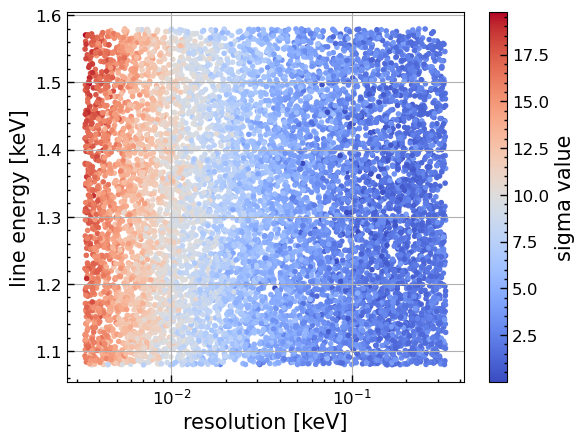

In [988]:
plt.figure()
plt.grid()
#plt.loglog()
plt.semilogx()

ax = plt.gca()

ax.set_xlabel(r'resolution [keV]')
ax.set_ylabel(r'line energy [keV]')

cdata = np.sqrt(chis_two2)
cnorm = mpl.colors.Normalize(vmax = max(cdata), vmin = min(cdata))
cmap = plt.cm.coolwarm

#ax.scatter(sigmas2, peaks2, c = np.sqrt(chis_two2), marker = '.', cmap = plt.cm.coolwarm)
ax.scatter(sigmas2, peaks2, c = cdata, marker = '.', cmap = cmap, norm = cnorm)

plt.colorbar(mpl.cm.ScalarMappable(norm = cnorm, cmap = cmap), ax = ax, orientation = 'vertical', label = 'sigma value')

In [1509]:
repeats = 1000
res0 = Resolution(0.02, verbosity = 0, bg_multiplier = bg_mult, random_radius = 0.5, opt_method = 'L-BFGS-B', signal_rate = 1e-20)
chis_repeat_test = np.zeros(repeats)
for i in tqdm.trange(repeats):
    chis_repeat_test[i] = res0.analyze_null(min_attempts = 10)


100%|██████████| 1000/1000 [14:15<00:00,  1.17it/s]


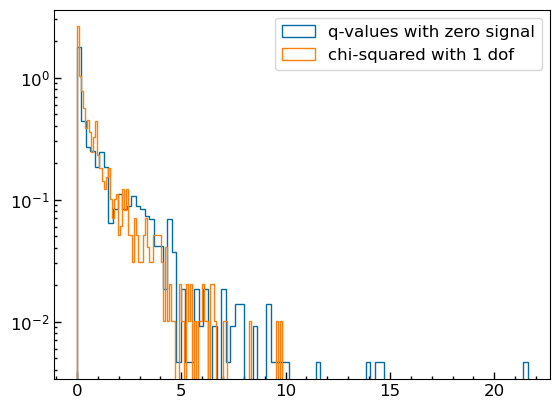

In [1607]:
chi1 = chi2.rvs(df = 1, size = repeats)
chi3 = chi2.rvs(df = 3, size = repeats)
Nother = 50
chi_other = chi2.rvs(df = Nother, size = repeats)
# [nb, ns, mu, sig]
hist_kwargs = {'bins': 100, 'histtype': 'step'}

plt.figure()
plt.hist(chis_repeat_test, density = True, label = 'q-values with zero signal', **hist_kwargs)
plt.hist(chi1, density = True, label = 'chi-squared with 1 dof', **hist_kwargs)
#plt.hist(chi3, density = True, label = '3 dof', **hist_kwargs)
#plt.hist(chi_other, density = True, label = f'{Nother} dof', **hist_kwargs)
plt.semilogy()
plt.legend()

Text(0, 0.5, 'probability $\\leq$3')

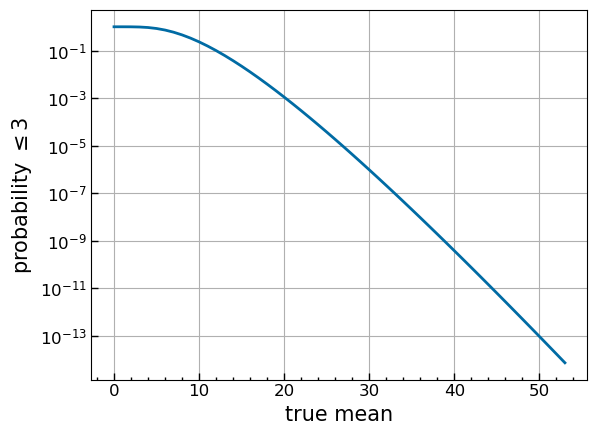

In [941]:


mus = np.arange(1, 55)
p = []

for mu in mus:

    p.append(poisson.cdf(8,mu))

plt.semilogy()
plt.plot(p)
plt.grid()
plt.xlabel('true mean')
plt.ylabel('probability $\\leq$3')

In [942]:
poisson.cdf(8, 40) # probability the actual mean is larger than 30 given meas = 3: 4.661032000779303e-10

8.569271064141678e-10

In [943]:

norm.sf(6)# p-value for typical standard normal 6-sigma value: 9.865876450376944e-10 (one-tailed)

9.865876450376944e-10

In [944]:
40e-6/E_nr

3.0082857504684675e-05

In [1010]:
norm.sf(2)

0.022750131948179198

In [1029]:
norm.cdf(8)

0.9999999999999993

In [945]:
# isf() is inverse of sf(), ppf() is inverse of cdf()
norm.isf(norm.sf(6)), norm.ppf(norm.cdf(-6))

(6.000000000000001, -6.000000000000001)

In [1574]:
sigmas_conf = np.array([10e-3, 20e-3, 40e-3, 80e-3]) # keV
peaks_conf = 4*[E_nr]
res_conf = []
Elow = E_nr - dE/2
Ehigh = E_nr + dE/2


# [nb, ns, mu, sig]

for i, (sigma, peak) in enumerate(zip(sigmas_conf, peaks_conf)):
    res_conf.append(Resolution(sigma, signal_rate = signal_rate, Ebounds = (Elow, Ehigh), E = peak, exposure = fourweeks, bg_multiplier = bg_mult))
    res_conf[-1].analyze()
    chis_two[i] = res.chi2
    chis_two2[i] = res.chi22


In [1560]:
res_conf[-1].opt.x[2]*res_conf[-1].E

1.2246174277244093

In [1563]:
Ls[-1].min() - res_conf[-1].L_ybg

0.1234988805372268

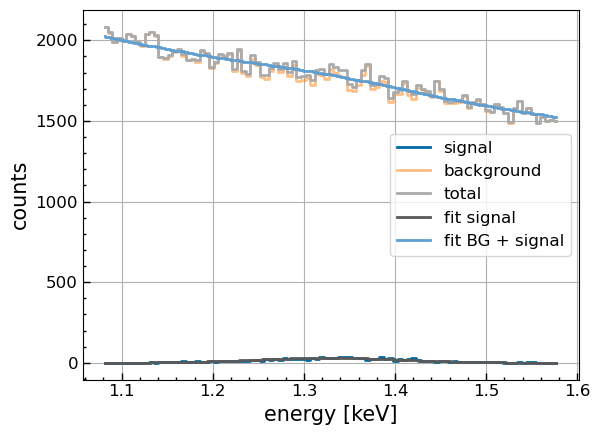

In [1578]:
res_conf[3].histogram(display_chi = 0)
#plt.savefig('../figures/sim_4wk_80eV_fluctuation.pdf')

0.02
1214 174596
1.8498904507261558 67.19195669610053 8.197070006782944
0.9958978385459781 1.054788206198121
1.324206436693577 21.09576412396242


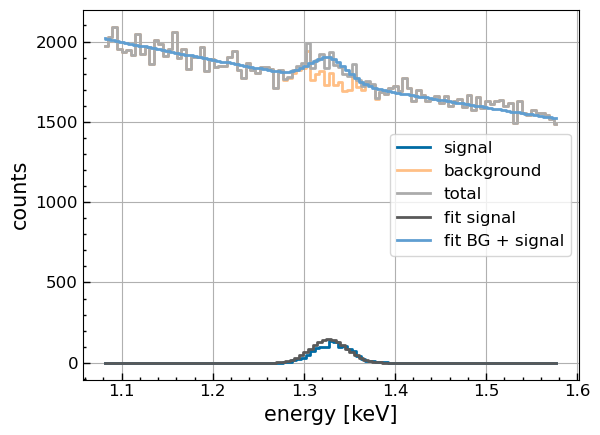

In [1586]:
res_plot = res_conf[1]

res_plot.histogram(display_chi = 0)
# [nb, ns, mu, sig]
print(res_plot.sigma)
print(res_plot.N_signal, res_plot.N_background) 
print(res_plot.chi2, res_plot.chi22, np.sqrt(res_plot.chi22))
print(res_plot.opt.x[2], res_plot.opt.x[3])
print(res_plot.opt.x[2]*res_plot.E, res_plot.opt.x[3]*res_plot.sigma*1e3)
#plt.savefig('../figures/sim_4wk_example.pdf')

In [ ]:
if 0:
    sigspace_1d = np.linspace(sigmas_conf.min()/2, sigmas_conf.max()*2, 200)
    peakspace_1d = np.linspace(E_nr - 0.15, E_nr + 0.15, 300)

    sigspace, peakspace = np.meshgrid(sigspace_1d, peakspace_1d, indexing = 'ij')

    Ls = []
    qs = []

    for i, (sigma, peak, res) in enumerate(zip(sigmas_conf, peaks_conf, res_conf)):
        
        #Lfunc = lambda mu, sig: res.L_ybg_func(np.array([np.ones(mu.shape), np.ones(mu.shape), mu/res.E, sig/res.sigma]))
        #Lfunc_single = lambda mu, sig: res.L_ybg_func(np.array([1, 1, mu/res.E, sig/res.sigma]))
        Lhere = res.contour(sigma_range = sigspace_1d, mu_range = peakspace_1d, repeat_minimum = 100, random_radius = 0.1)
        #Lfunc = np.vectorize(Lfunc_single)
        Ls.append(Lhere)
        #Ls = res.L_ybg - Lfunc(peakspace, sigspace)
        qs.append(2*(Lhere - res.L_ybg))
        print(Lhere.shape, Ls[-1].shape, qs[-1].shape)


(200, 300) (200, 300) (200, 300)
(200, 300) (200, 300) (200, 300)
(200, 300) (200, 300) (200, 300)
(200, 300) (200, 300) (200, 300)


        10.0 & 5.534 & 6.071 \\
        \hline
        20.0 & 17.36 & 15.22 \\
        \hline
        40.0 & 62.55 & 69.94 \\
        \hline
        80.0 & 86.35 & 120.6 \\
        \hline


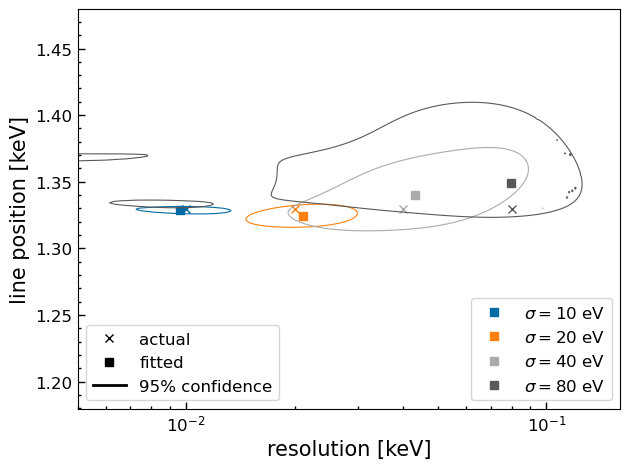

In [1625]:

contour_val = 0.95
#lambda0 = norm.isf((1-contour_val)/2)**2
qref = chi2.ppf(contour_val, df = 2)

plt.figure()
#plt.grid()
ax = plt.gca()

main_colors = []
main_handles = []

for i, (sigma, peak, res) in enumerate(zip(sigmas_conf, peaks_conf, res_conf)):
    

    true, = ax.plot([res.sigma], [res.E], 'x', alpha = 1)

    ideal, = ax.plot([res.opt.x[3]*res.sigma], [res.opt.x[2]*res.E], 's', color = true.get_color(), label = f'$\\sigma={sigma*1e3:.0f}$ eV')
    main_handles.append(ideal)
    main_colors.append(true.get_color())


    c = ax.contour(sigspace, peakspace, qs[i], levels = [qref], colors = [true.get_color()], linewidths = [0.8])
    #ax.clabel(c, c.levels, inline = True, fmt = lambda x: f'95\%')

    vertices = c.get_paths()[0].vertices
    xc = vertices[:,0]
    yc = vertices[:,1]

    #plt.plot(xc, yc, 'k*')


    ixs, jxs = np.where(qs[i] < qref)
    mulow, muhigh = peakspace_1d[[jxs.min(), jxs.max()]]
    siglow, sighigh = sigspace_1d[[ixs.min(), ixs.max()]]
    #print('sigma =', sigma*1e3, 'eV')
    #print('mean:', mulow, muhigh, f'{(muhigh-mulow):.4g} keV range', f'{1e3*(yc.max()-yc.min()):.4g} eV range')
    #print('width:', siglow, sighigh, f'{(sighigh-siglow):.4g} keV range', f'{1e3*(xc.max()-xc.min()):.4g} eV range')
    #print('-------')
    print(8*' ' + f'{sigma*1e3} & {1e3*(yc.max()-yc.min()):.4g} & {1e3*(xc.max()-xc.min()):.4g} \\\\')
    print(8*' ' + '\\hline')


ax = plt.gca()

plt.semilogx()
#plt.axhline(E_nr, linestyle = 'dashed', color = 'k', linewidth = 0.8)
plt.xlabel('resolution [keV]')
plt.ylabel('line position [keV]')
#legend1 = ax.legend(handles = [mpl.lines.Line2D([], [], color = c, marker = 's', linestyle = '', label = f'{s*1e3}') for c, s in zip(main_colors, sigmas_conf)], loc = 'upper right')
legend1 = ax.legend(handles = main_handles, loc = 'lower right')


# add second legend for marker types
x_artist = mpl.lines.Line2D([], [], color = 'k', marker = 'x', linestyle = '', label = 'actual')
square_artist = mpl.lines.Line2D([], [], color = 'k', marker = 's', linestyle = '', label = 'fitted')
line_artist = mpl.lines.Line2D([], [], color = 'k', label = '95% confidence')

legend2 = ax.legend(handles = [x_artist, square_artist, line_artist], loc = 'lower left')
ax.add_artist(legend1)
window = ax.axis()
plt.tight_layout()
plt.savefig('../figures/sim_4wk_95contours.pdf')
#plt.ylim(1.3,1.35)

In [1631]:
qref

5.99146454710798

In [1639]:
dat.min(), dat.max()

(nan, nan)

In [1644]:
qs[i].min(), qs[i].max()

(0.1269101109355688, 158.31020210124552)

In [1651]:
chi2.ppf(qs[i].min(), df = 2), chi2.ppf(0.95, df = 2)

(0.27143352546719307, 5.99146454710798)

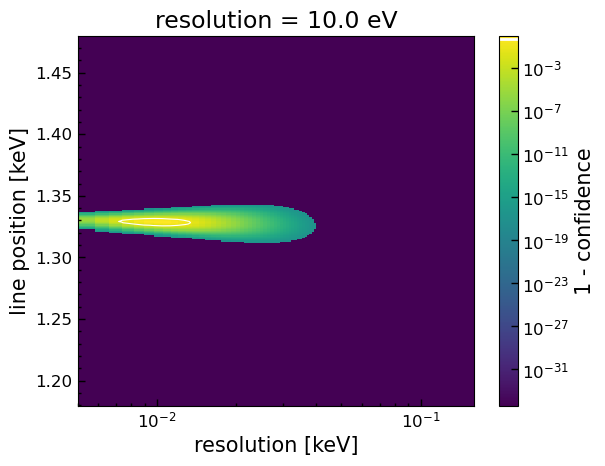

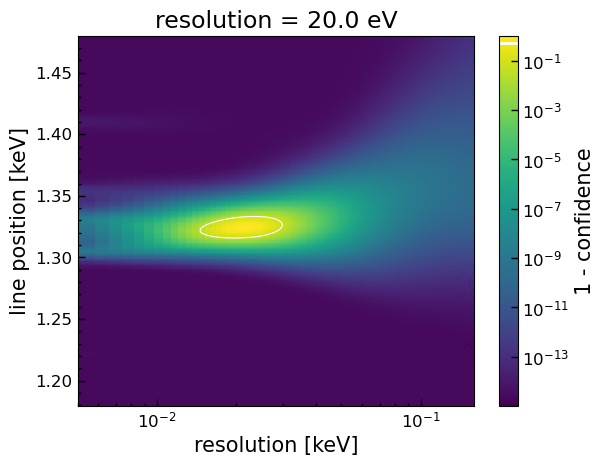

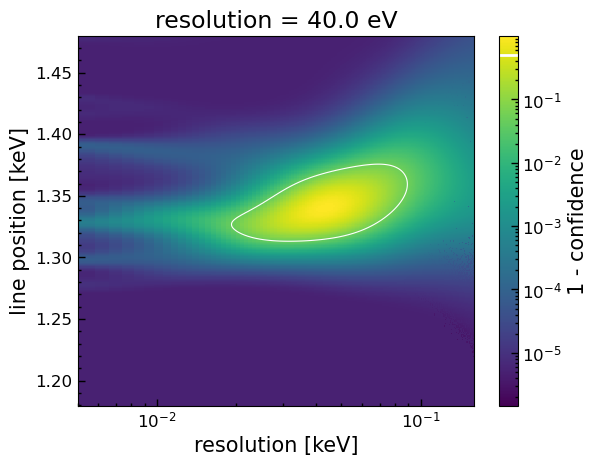

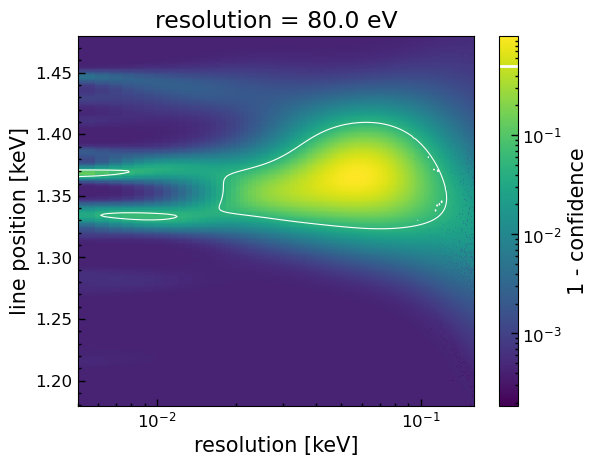

In [1683]:
for i, (sigma, peak, res) in enumerate(zip(sigmas_conf, peaks_conf, res_conf)):
    dat = chi2.sf(qs[i][:,::-1].T, df = 2)
    cnorm = mpl.colors.LogNorm(vmax = dat.max(), vmin = dat.min())
    #cnorm = mpl.colors.LogNorm(vmax = 1, vmin = 0.8)
    cmap = plt.cm.viridis

    plt.figure()
    plt.semilogx()
    plt.title(f'resolution = {sigma*1e3} eV')
    img = plt.imshow(dat, cmap = cmap, norm = cnorm, aspect = 'auto', interpolation = 'None', extent = window)
    #plt.contour(sigspace, peakspace, chi2.cdf(qs[i], df = 2), levels = [qref], colors = ['w'], linewidths = [0.8])
    plt.contour(sigspace, peakspace, chi2.cdf(qs[i], df = 2), levels = [0.95], colors = ['w'], linewidths = [0.8])

    cb = plt.colorbar(img, ax = plt.gca(), label = '1 - confidence')
    cb.ax.axhline(0.5, color = 'w')
    plt.xlabel('resolution [keV]')
    plt.ylabel('line position [keV]')

In [1684]:
help(np.savetxt)

Help on _ArrayFunctionDispatcher in module numpy:

savetxt(fname, X, fmt='%.18e', delimiter=' ', newline='\n', header='', footer='', comments='# ', encoding=None)
    Save an array to a text file.
    
    Parameters
    ----------
    fname : filename or file handle
        If the filename ends in ``.gz``, the file is automatically saved in
        compressed gzip format.  `loadtxt` understands gzipped files
        transparently.
    X : 1D or 2D array_like
        Data to be saved to a text file.
    fmt : str or sequence of strs, optional
        A single format (%10.5f), a sequence of formats, or a
        multi-format string, e.g. 'Iteration %d -- %10.5f', in which
        case `delimiter` is ignored. For complex `X`, the legal options
        for `fmt` are:
    
        * a single specifier, `fmt='%.4e'`, resulting in numbers formatted
          like `' (%s+%sj)' % (fmt, fmt)`
        * a full string specifying every real and imaginary part, e.g.
          `' %.4e %+.4ej %.4e %+

In [1686]:
for qvals, sig in zip(qs, sigmas_conf):
    np.savetxt(f'analysis_data/q_array_{sig*1e3:.0f}eV.txt', qvals)

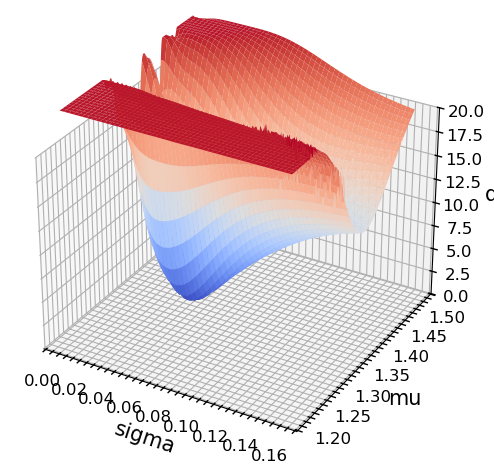

In [ ]:
#%matplotlib inline
#%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
idx = 3

ax.plot_surface(sigspace, peakspace, qs[2], cmap = mpl.cm.coolwarm)

ax.set_xlabel('sigma')
ax.set_ylabel('mu')
ax.set_zlabel('q')

ax.set_zlim(0, 20)
fig.tight_layout()

In [1419]:
fig.tight_layout()

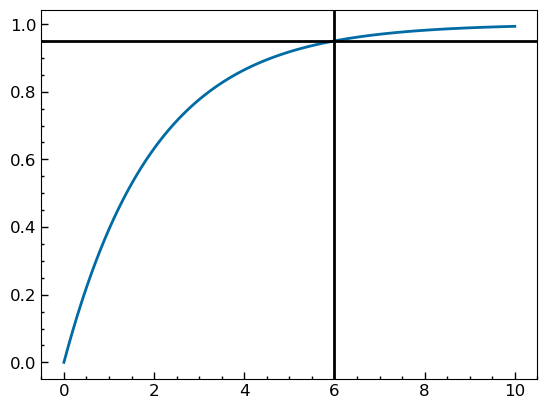

In [ ]:
x = np.linspace(0,10,100)
cumulative = chi2.cdf(x, df = 2)
chi_standard = chi2.ppf(0.95, df = 2)

plt.plot(x, cumulative)
plt.axvline(chi_standard, color = 'k')
plt.axhline(0.95, color = 'k')

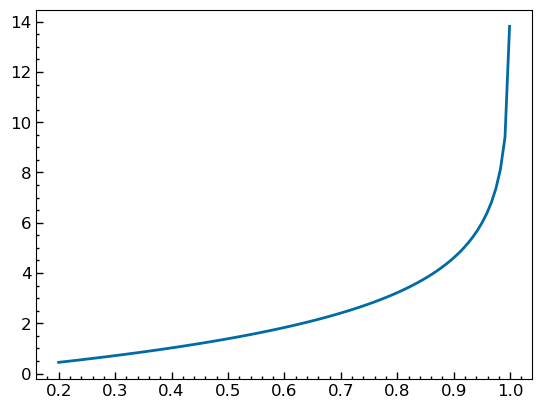

In [1454]:
Pvals = np.linspace(0.2, 0.999, 100) #np.array([0.999, 0.99, 0.95, 0.85, 0.5, 0.1])
qvals = chi2.ppf(Pvals, df = 2)

plt.plot(Pvals, qvals)

In [1589]:
res.Nbins

100

In [1422]:
res.Ebins[0], res.Ebins[-1], res.E

(1.079660920468442, 1.579660920468442, 1.329660920468442)

[]

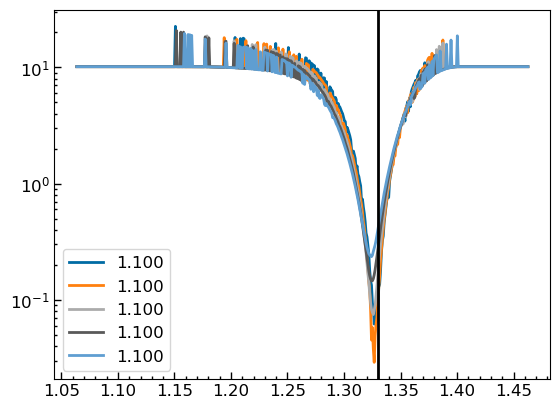

In [1423]:
Elow = E_nr - dE/2
Ehigh = E_nr + dE/2
peak = E_nr
sigma = 40e-3

res = Resolution(sigma, signal_rate = signal_rate, Ebounds = (Elow, Ehigh), E = peak, exposure = fourweeks, bg_multiplier = bg_mult)


sigmas = np.linspace(0.9, 1.1, 5)*res.sigma
mus = np.linspace(0.8, 1.1, 500)*res.E
Ls = res.contour(sigma_range = sigmas, mu_range = mus)


plt.figure()

for i, sig in enumerate(sigmas):
    plt.plot(mus, Ls[i] - res.L_ybg, label = f'{mu/res.E:.3f}')


plt.axvline(res.E, color = 'k')
#plt.axhline(res.L_ybg, color = 'k')
#plt.axhline(0, color = 'k')
plt.legend()
plt.semilogy()


In [1424]:
res.opt

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -1140269.1355993648
        x: [ 1.000e+00  9.290e-01  9.981e-01  9.229e-01]
      nit: 18
      jac: [-4.932e-02  6.122e-03 -3.027e-02  5.245e-01]
     nfev: 22
     njev: 22
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [1600]:
Ntrials = 1000
best_resolution = 400
worst_resolution = 4
sigmas = E_nr*np.exp(np.log(1/best_resolution) + (np.log(1/worst_resolution) - np.log(1/best_resolution))*rng.random(size = Ntrials))
chis_1 = np.zeros(sigmas.shape)
chis_2 = np.zeros(sigmas.shape)

for i, sigma in enumerate(tqdm.tqdm(sigmas)):
    res1 = Resolution(sigma, signal_rate = signal_rate, exposure = fourweeks, bg_multiplier = bg_mult)
    res2 = Resolution(sigma, signal_rate = signal_rate, exposure = fourweeks, bg_multiplier = bg_mult, Nbins = 200)
    keepgoing = True
    while keepgoing:
        try:
            res1.analyze()
            chis_1[i] = res1.chi22
            keepgoing = False
        except:
            pass
    keepgoing = True
    while keepgoing:
        try:
            res2.analyze()
            chis_2[i] = res2.chi22
            keepgoing = False
        except:
            pass


100%|██████████| 1000/1000 [00:35<00:00, 28.28it/s]


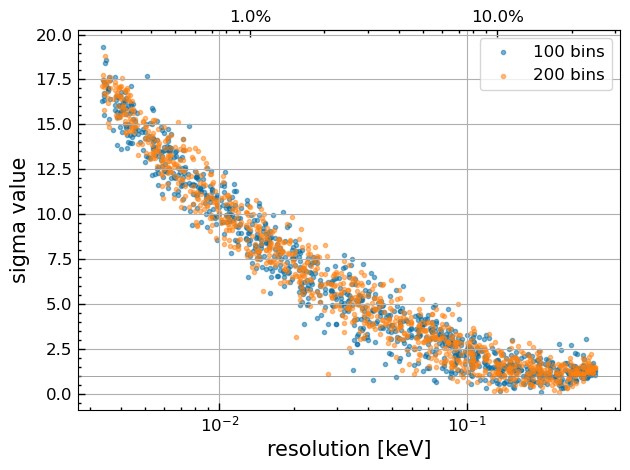

In [1601]:
sigma_plot = sigmas#np.sqrt(sigmas**2 - sigma_F**2)
plt.figure()
ax = plt.gca()
ax.semilogx()
#ax.set_title('chi-squared vs. resolution in highmass')
ax.set_xlabel(r'resolution [keV]')
ax.set_ylabel('sigma value')
ax.axhline(1, color = 'grey', linewidth = 0.5)
ax.scatter(sigma_plot, np.sqrt(chis_1), marker = '.', alpha = 0.5, label = f'{res1.Nbins} bins')
ax.scatter(sigma_plot, np.sqrt(chis_2), marker = '.', alpha = 0.5, label = f'{res2.Nbins} bins')
#ax.set_ylim(wind0[2], 3*wind0[3])


#ax.grid(axis = 'x')
ax.grid()
ax.legend()

E_to_P = lambda E: 100*E/(E_nr)
P_to_E = lambda P: E_nr*P/100

x2 = ax.secondary_xaxis('top', functions = (E_to_P, P_to_E))
#x2.set_xlabel('percent resolution (%)')
x2.get_xaxis().set_major_formatter('{x}%')


plt.tight_layout()